# ©2023 EDF
Adrien PETRALIA - EDF R&D and Université Paris Cité (LIPADE)

# ADF & TransApp - Notebook example
## A Transformer-Based Framework for Appliance Detection Using Smart Meter Consumption Series 

In [1]:
import os, sys
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn

root = Path(os.getcwd()).resolve().parents[0]
sys.path.append(str(root))
from experiments.data_utils import *
from src.TransAppModel.TransApp import *
from src.AD_Framework.Framework import *
from src.utils.losses import *

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

## Instantiation of a TransApp Model

In [2]:
def get_model_inst(m, win, dim_model, mode="pretraining", large_version=False, path_select_core=None):
    """
    Description:
        Get TransApp model instance
    
    Parameters:
        m: int - n channel of input time series
        win: int - length of input subsequence (usefull for positional encoding, if any)
        mode: str - 'pretraining' or 'classif' (type of head)
        large_version: boolean - if true, use 5 encoder layers instead of 3
        path_select_core: str - path to pretrained instance of TransApp 
    """

    TApp = TransApp(max_len=win, c_in=m,
                    mode=mode,
                    n_embed_blocks=1, 
                    encoding_type='noencoding',
                    n_encoder_layers=5 if large_version else 3,
                    kernel_size=5,
                    d_model=dim_model, pffn_ratio=2, n_head=4,
                    prenorm=True, norm="LayerNorm",
                    activation='gelu',
                    store_att=False, attn_dp_rate=0.2, head_dp_rate=0., dp_rate=0.2,
                    att_param={'attenc_mask_diag': True, 'attenc_mask_flag': False, 'learnable_scale_enc': False},
                    c_reconstruct=1, apply_gap=True, nb_class=2)

    if path_select_core is not None:
        TApp.load_state_dict(torch.load(path_select_core)['model_state_dict'])

    return TApp

## Self-supervised pretraining

In [3]:
m       = 1    # Number of channel of the input time series (i.e. consumption time series, hours encoded in sin/cos based , days encoded in sin/cos based)
win     = 1024 # Choseen length of slicing window size
d_model = 96   # Inner dimension of the model

TransAppInstance = get_model_inst(m=m, win=win, dim_model=d_model, mode="pretraining") # Pretraining mode of our TransApp model

summary(TransAppInstance, input_size=(1, m, win), mode="train", device='cuda') # show TransApp architecture with pretraining head

Layer (type:depth-idx)                                  Output Shape              Param #
TransApp                                                [1, 1, 1024]              194
├─Sequential: 1-1                                       [1, 1024, 96]             --
│    └─DilatedBlock: 2-1                                [1, 96, 1024]             --
│    │    └─Sequential: 3-1                             [1, 96, 1024]             139,872
│    └─Transpose: 2-2                                   [1, 1024, 96]             --
├─Sequential: 1-2                                       [1, 1024, 96]             --
│    └─EncoderLayer: 2-3                                [1, 1024, 96]             --
│    │    └─LayerNorm: 3-2                              [1, 1024, 96]             192
│    │    └─AttentionLayer: 3-3                         [1, 1024, 96]             37,248
│    │    └─LayerNorm: 3-4                              [1, 1024, 96]             192
│    │    └─PositionWiseFeedForward: 3-5        

### Get pretraining data

In [4]:
# data_pretraining = CER_get_data_pretraining(exo_variable=['hours_cos', 'hours_sin', 'days_cos', 'days_sin'])
data_pretraining = COMSTOCK_get_data_pretraining(resolution='15min')

Loaded ComStock 15min data for pretraining: (1000, 35040)
Applied entire curve normalization
Pretraining data shape: (34000, 1, 1024)


### Pretrainer instance

In [5]:
dict_params = {'lr': 1e-4, 'wd': 1e-4, 'batch_size': 16, 'epochs': 1}

#create the tmp folder if it does not exist

save_path = str(root) + '/tmp/TransAppPT' # Model save path
# Create tmp directory if it doesn't exist
tmp_dir = Path(root) / 'tmp'
tmp_dir.mkdir(exist_ok=True)

pretraining_dataset = TSDataset(data_pretraining, scaler=True, scale_dim=[0])
train_loader = torch.utils.data.DataLoader(pretraining_dataset, batch_size=dict_params['batch_size'], shuffle=True)

GeomMask = GeometricMask(mean_length=24, masking_ratio=0.5, type_corrupt='zero', dim_masked=0) # Mask to corrupt inout time series

model_pretrainer = self_pretrainer(TransAppInstance,                                     
                                   train_loader, valid_loader=None,
                                   learning_rate=dict_params['lr'], weight_decay=dict_params['wd'],
                                   name_scheduler='CosineAnnealingLR',
                                   dict_params_scheduler={'T_max': dict_params['epochs'], 'eta_min': 1e-6},
                                   warmup_duration=None,
                                   criterion=MaskedMSELoss(type_loss='L1'), mask=GeomMask,
                                   device="cuda", all_gpu=False,
                                   verbose=True, plotloss=True, 
                                   save_fig=False, path_fig=None,
                                   save_only_core=False,
                                   save_checkpoint=True, path_checkpoint=save_path)

### Training process

In [11]:
model_pretrainer.train(dict_params['epochs'])

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 

## Finetuning the pretrained model for Appliance Detection (i.e., a chosen classification case)

In [10]:
TransAppInstance.mode = "classif" # Change the mode of the TransApp architecture, i.e. use a classification head
# OR
#TransAppInstance = get_model_inst(m=m, win=win, dim_model=d_model, mode="classif", path_select_core= str(root) + '/tmp/TransAppPT.pt') # Load previous pretrained instance

summary(TransAppInstance, input_size=(1, m, win), mode="train", device='cpu') # show TransApp architecture with classification head

Layer (type:depth-idx)                                  Output Shape              Param #
TransApp                                                [1, 2]                    97
├─Sequential: 1-1                                       [1, 1024, 96]             --
│    └─DilatedBlock: 2-1                                [1, 96, 1024]             --
│    │    └─Sequential: 3-1                             [1, 96, 1024]             142,368
│    └─Transpose: 2-2                                   [1, 1024, 96]             --
├─Sequential: 1-2                                       [1, 1024, 96]             --
│    └─EncoderLayer: 2-3                                [1, 1024, 96]             --
│    │    └─LayerNorm: 3-2                              [1, 1024, 96]             192
│    │    └─AttentionLayer: 3-3                         [1, 1024, 96]             37,248
│    │    └─LayerNorm: 3-4                              [1, 1024, 96]             192
│    │    └─PositionWiseFeedForward: 3-5         

### Select a possible detection case on CER dataset

- cooker_case
- dishwasher_case
- waterheater_case
- pluginheater_case
- tumbledryer_case
- tv_greater21inch_case
- tv_lessr21inch_case
- desktopcomputer_case
- laptopcomputer_case

In [11]:
case = 'cooker_case' # exemple of detecting cooker in consumption series

datas_tuple = CER_get_data_case('cooker_case', seed=0, exo_variable=['hours_cos', 'hours_sin', 'days_cos', 'days_sin'], win=win)

### AD Framework instance and training

In [12]:
dict_params = {'lr': 1e-4, 'wd': 1e-3, 'batch_size': 16, 'epochs': 10, 'p_es': 5, 'p_rlr': 3, 'n_warmup_epochs': 1}
save_path = str(root) + '/tmp/TransAppPTFinetuned'

# Scliced data for training
X_train = datas_tuple[0]
y_train = datas_tuple[1]
X_valid = datas_tuple[2]
y_valid = datas_tuple[3]
X_test  = datas_tuple[4]
y_test  = datas_tuple[5]

# Entire curves data for evaluate the model
X_train_voter = datas_tuple[6]
y_train_voter = datas_tuple[7]
X_valid_voter = datas_tuple[8]
y_valid_voter = datas_tuple[9]
X_test_voter  = datas_tuple[10]
y_test_voter  = datas_tuple[11]

# Dataset
train_dataset = TSDataset(X_train, y_train, scaler=True, scale_dim=[0])
valid_dataset = TSDataset(X_valid, y_valid, scaler=True, scale_dim=[0])
test_dataset  = TSDataset(X_test,  y_test,  scaler=True, scale_dim=[0])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=dict_params['batch_size'], shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=True)

# AD Framework trainer
model_trainer = AD_Framework(TransAppInstance,
                             train_loader=train_loader, valid_loader=valid_loader,
                             learning_rate=dict_params['lr'], weight_decay=dict_params['wd'],
                             criterion=nn.CrossEntropyLoss(),
                             patience_es=dict_params['p_es'], patience_rlr=dict_params['p_rlr'],
                             f_metrics=getmetrics(),
                             n_warmup_epochs=dict_params['n_warmup_epochs'],
                             scale_by_subseq_in_voter=True, scale_dim=[0],
                             verbose=True, plotloss=True, 
                             save_fig=False, path_fig=None,
                             device="cuda", all_gpu=False,
                             save_checkpoint=True, path_checkpoint=save_path)

### Training process

Epoch [1/10]
    Train loss : 0.6287, Train acc : 65.02%
    Valid  loss : 0.5774, Valid  acc : 74.43%
Epoch [2/10]
    Train loss : 0.5904, Train acc : 69.06%
    Valid  loss : 0.5581, Valid  acc : 74.57%
Epoch [3/10]
    Train loss : 0.5715, Train acc : 70.93%
    Valid  loss : 0.5686, Valid  acc : 72.63%
Epoch [4/10]
    Train loss : 0.5555, Train acc : 72.17%
    Valid  loss : 0.5570, Valid  acc : 74.06%
Epoch [5/10]
    Train loss : 0.5396, Train acc : 73.28%
    Valid  loss : 0.5335, Valid  acc : 75.21%
Epoch [6/10]
    Train loss : 0.5249, Train acc : 74.24%
    Valid  loss : 0.6050, Valid  acc : 70.70%
Epoch [7/10]
    Train loss : 0.5063, Train acc : 75.40%
    Valid  loss : 0.5839, Valid  acc : 74.42%
Epoch [8/10]
    Train loss : 0.4931, Train acc : 76.50%
    Valid  loss : 0.5867, Valid  acc : 74.92%
Epoch     9: reducing learning rate of group 0 to 1.0000e-05.
Epoch [9/10]
    Train loss : 0.4742, Train acc : 77.63%
    Valid  loss : 0.6597, Valid  acc : 70.38%
Early stopp

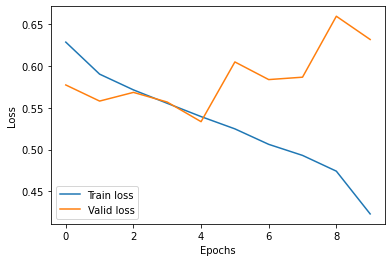

In [13]:
model_trainer.train(dict_params['epochs'])

### Model evaluation

In [14]:
#============ eval last model on subsequences ============#
model_trainer.evaluate(torch.utils.data.DataLoader(test_dataset, batch_size=1), mask='test_metrics_lastmodel')

#============ restore best weight ============#    
model_trainer.restore_best_weights()

#============ eval model on subsequences  ============#   
model_trainer.evaluate(torch.utils.data.DataLoader(test_dataset, batch_size=1))

#============ find best quantile on valid voter dataset ============#
model_trainer.ADFFindBestQuantile(TSDataset(X_valid_voter, y_valid_voter), m=m, win=win)

#============ evaluate on test voter dataset using best quantile ============#
quant_metric = model_trainer.ADFvoter_proba(TSDataset(X_test_voter, y_test_voter), m=m, win=win)
print(quant_metric)

Restored best model met during training.
{'ACCURACY': 0.7403156384505022, 'PRECISION': 0.4696969696969697, 'RECALL': 0.5502958579881657, 'PRECISION_MACRO': 0.6586961802392663, 'RECALL_MACRO': 0.6757161108122647, 'F1_SCORE': 0.5068119891008176, 'F1_SCORE_MACRO': 0.6652852545309347, 'F1_SCORE_WEIGHTED': 0.7469092176434339, 'CONFUSION_MATRIX': array([[ 93,  76],
       [105, 423]]), 'ROC_AUC_SCORE': 0.7523085888470503, 'ROC_AUC_SCORE_MACRO': 0.7523085888470503, 'ROC_AUC_SCORE_WEIGHTED': 0.7523085888470503}
